<a href="https://colab.research.google.com/github/kimhwijin/TensorflowWithKeras/blob/master/UNSUPERVISED/VAE_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from    PIL import Image

In [24]:
np.random.seed(11)
tf.random.set_seed(11)

In [25]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train.astype(np.float32) / 255.0 , x_test.astype(np.float32) / 255.0
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

#이미지 변수
new_im = Image.new('L', (280, 280))

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


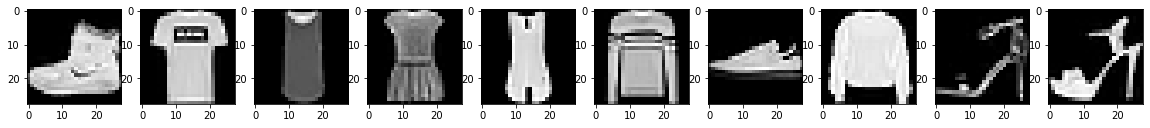

In [26]:
#데이터셋의 샘플 사진
number = 10
plt.figure(figsize=(20,4))
for index in range(number):
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_train[index], cmap='gray')
plt.show()

In [27]:
#하이퍼 파라미터
image_size = 28*28
h_dim = 512
z_dim = 10
num_epochs = 80
batch_size = 100
learning_rate = 1e-3

In [28]:
#VAE model class

class VAE(tf.keras.Model):
    """
    Encoder : input x 에서 아직 모르는 z 에 관해 E(z)_평균, log(V(z))_로그분산을 생성한다.
    Sampler : 생성한 평균과 분산을 통해서, 가우시안 분포를 따르는 잠재 변수 z를 샘플링한다.
    Decoder : z를 통해 x_hat 을 reconstruction 한다.
    
    Sampling Trick : 임의로 Sampling 할경우, z를 통해 h_hat을 생성하고, loss 를 통해서 역전파를 실시해야하는데, Sampling의 경우 불가능하다.
    따라서, Sampling 할때 특정 식을 통해서 분포 z를 생성한다.
    z = E(z) + ϵ * sqrt(V(z)) (ϵ : 0,1 의 정규분포)
​
    """
    def __init__(self):
        super(VAE, self).__init__()

        # input => h
        self.fc1 = tf.keras.layers.Dense(h_dim)
        # h => mu and variance
        #히든 레이어에서 기대값(평균값)과 log(분산)을 구하는 layer
        self.fc2 = tf.keras.layers.Dense(z_dim)
        self.fc3 = tf.keras.layers.Dense(z_dim)

        # sampled z => h
        self.fc4 = tf.keras.layers.Dense(h_dim)
        # h => image
        self.fc5 = tf.keras.layers.Dense(image_size)


    def encode(self, x):
        h = tf.nn.relu(self.fc1(x))
        # mu, log_variance
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        """
        reparametrize trick
        :param mu:
        :param log_var:
        :return:
        """

        std = tf.exp(log_var * 0.5)
        #엡실론
        eps = tf.random.normal(std.shape)
        return mu + eps * std

    def decode_logits(self, z):
        h = tf.nn.relu(self.fc4(z))
        return self.fc5(h)

    def decode(self, z):
        return tf.nn.sigmoid(self.decode_logits(z))

    def call(self, inputs, training=None, mask=None):
        # encoder
        mu, log_var = self.encode(inputs)
        # sample
        z = self.reparameterize(mu, log_var)
        # decode
        x_reconstructed_logits = self.decode_logits(z)

        return x_reconstructed_logits, mu, log_var

In [29]:
model = VAE()
model.build(input_shape=(4, image_size))
model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate)

Model: "vae_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             multiple                  401920    
_________________________________________________________________
dense_11 (Dense)             multiple                  5130      
_________________________________________________________________
dense_12 (Dense)             multiple                  5130      
_________________________________________________________________
dense_13 (Dense)             multiple                  5632      
_________________________________________________________________
dense_14 (Dense)             multiple                  402192    
Total params: 820,004
Trainable params: 820,004
Non-trainable params: 0
_________________________________________________________________


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(batch_size * 5).batch(batch_size)

num_batches = x_train.shape[0] // batch_size

for epoch in range(num_epochs):

    for step, x in enumerate(dataset):

        x = tf.reshape(x, [-1, image_size])

        with tf.GradientTape() as tape:

            # Forward pass
            x_reconstruction_logits, mu, log_var = model(x)

            # Compute reconstruction loss and kl divergence
            # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
            # Scaled by `image_size` for each individual pixel.
            
            #재생성한 이미지와 원래 이미지의 차이
            reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_reconstruction_logits)
            reconstruction_loss = tf.reduce_sum(reconstruction_loss) / batch_size

            #잠재 분포 z 차이
            #q(z|x) , p(z) 와의 KL DIV 이때, p(z)는 0,1인 정규분포이므로,
            #D_KL(q(z|x), p(z) = 1/2∑i=1(σ2i+μ2i−ln(σ2i)−1) 로 나타낼수 있다.
            kl_div = - 0.5 * tf.reduce_sum(1. + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
            kl_div = tf.reduce_mean(kl_div)

            loss = tf.reduce_mean(reconstruction_loss) + kl_div

        gradients = tape.gradient(loss, model.trainable_variables)
        for g in gradients:
            tf.clip_by_norm(g, 15)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if (step + 1) % 50 == 0:
            print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}".format(epoch + 1, num_epochs, step + 1, num_batches, float(reconstruction_loss), float(kl_div)))

    z = tf.random.normal((batch_size, z_dim))
    out = model.decode(z)  # decode with sigmoid
    out = tf.reshape(out, [-1, 28, 28]).numpy() * 255
    out = out.astype(np.uint8)

    # Save the reconstructed images of last batch
    out_logits, _, _ = model(x[:batch_size // 2])
    out = tf.nn.sigmoid(out_logits)  # out is just the logits, use sigmoid
    out = tf.reshape(out, [-1, 28, 28]).numpy() * 255

    x = tf.reshape(x[:batch_size // 2], [-1, 28, 28])

    x_concat = tf.concat([x, out], axis=0).numpy() * 255.
    x_concat = x_concat.astype(np.uint8)

    index = 0
    for i in range(0, 280, 28):
        for j in range(0, 280, 28):
            im = x_concat[index]
            im = Image.fromarray(im, mode='L')
            new_im.paste(im, (i, j))
            index += 1

    new_im.save('images/vae_reconstructed_epoch_%d.png' % (epoch + 1))
    plt.imshow(np.asarray(new_im))
    plt.show()
    print('New images saved !')